In [134]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [135]:
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Dense, Activation
import nltk
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import subjectivity
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.util import *
from sklearn import preprocessing, metrics
from sklearn.preprocessing import MinMaxScaler

In [136]:
df = pd.read_csv('/content/drive/MyDrive/AAPL.csv')
df

,Date,Open,High,Low,Close,Adj Close,Volume,ts_polarity,twitter_volume
0,2016-01-04,25.65,26.34,25.50,26.34,24.44,270597600,0.070389,1133.0
1,2016-01-05,26.44,26.46,25.60,25.68,23.83,223164000,0.133635,1430.0
2,2016-01-06,25.14,25.59,24.97,25.17,23.36,273829600,0.072042,1949.0
3,2016-01-07,24.67,25.03,24.11,24.11,22.38,324377600,0.074369,2289.0
4,2016-01-08,24.64,24.78,24.19,24.24,22.50,283192000,0.051595,2235.0
...,...,...,...,...,...,...,...,...,...
1183,2020-09-15,118.33,118.83,113.61,115.54,115.54,184642000,NaN,NaN
1184,2020-09-16,115.23,116.00,112.04,112.13,112.13,154679000,NaN,NaN
1185,2020-09-17,109.72,112.20,108.71,110.34,110.34,178011000,NaN,NaN
1186,2020-09-18,110.40,110.88,106.09,106.84,106.84,287104900,NaN,NaN


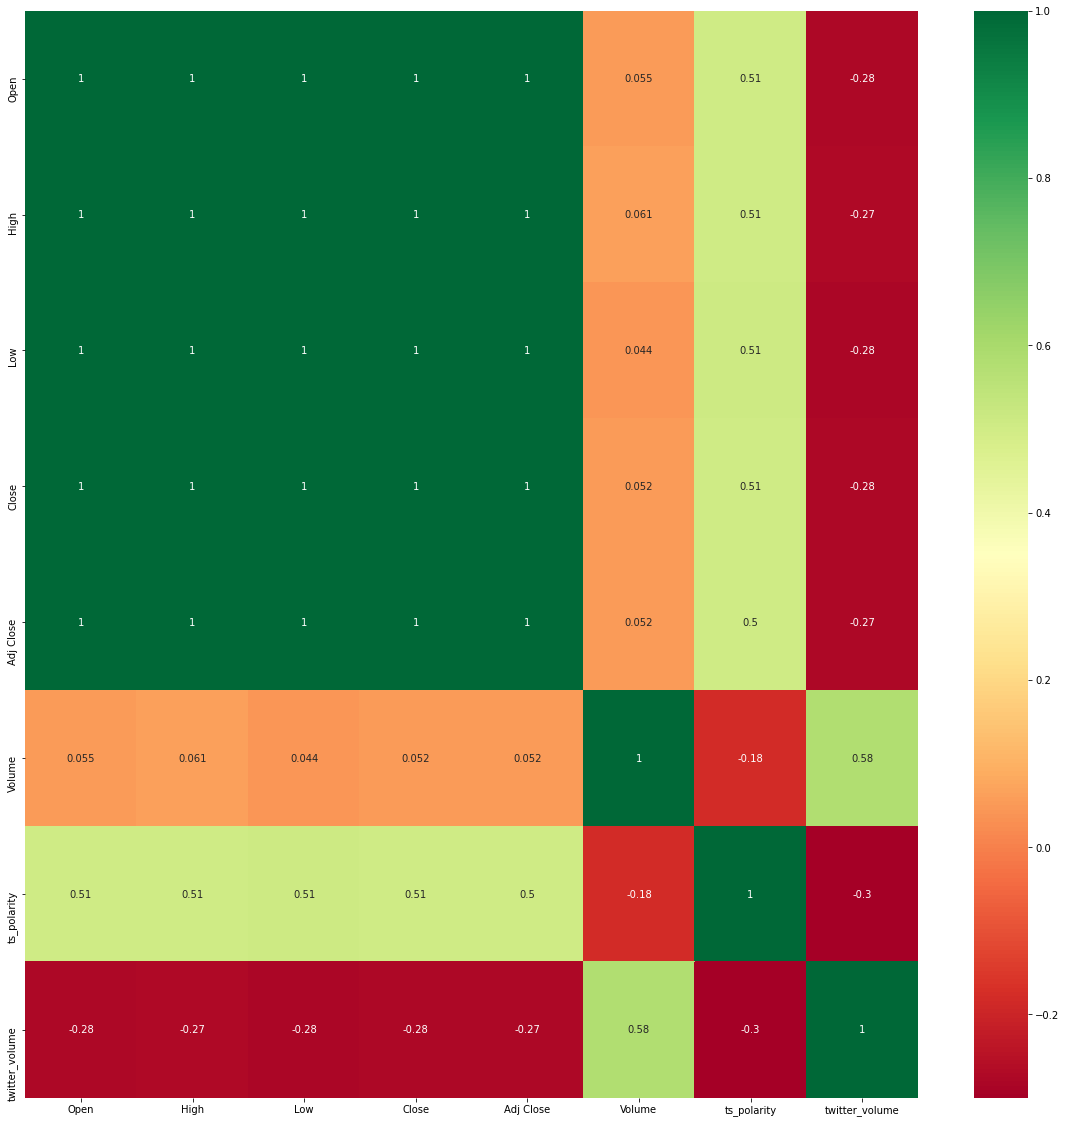

In [137]:
import seaborn as sns
#get correlations of each features in dataset
corrmat = df.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(df[top_corr_features].corr(),annot=True,cmap="RdYlGn")

In [138]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,ts_polarity,twitter_volume
0,2016-01-04,25.65,26.34,25.50,26.34,24.44,270597600,0.070389,1133.0
1,2016-01-05,26.44,26.46,25.60,25.68,23.83,223164000,0.133635,1430.0
2,2016-01-06,25.14,25.59,24.97,25.17,23.36,273829600,0.072042,1949.0
3,2016-01-07,24.67,25.03,24.11,24.11,22.38,324377600,0.074369,2289.0
4,2016-01-08,24.64,24.78,24.19,24.24,22.50,283192000,0.051595,2235.0


In [139]:
df = df.dropna()
df.isna().any()

Date              False
Open              False
High              False
Low               False
Close             False
Adj Close         False
Volume            False
ts_polarity       False
twitter_volume    False
dtype: bool

In [140]:
df

,Date,Open,High,Low,Close,Adj Close,Volume,ts_polarity,twitter_volume
0,2016-01-04,25.65,26.34,25.50,26.34,24.44,270597600,0.070389,1133.0
1,2016-01-05,26.44,26.46,25.60,25.68,23.83,223164000,0.133635,1430.0
2,2016-01-06,25.14,25.59,24.97,25.17,23.36,273829600,0.072042,1949.0
3,2016-01-07,24.67,25.03,24.11,24.11,22.38,324377600,0.074369,2289.0
4,2016-01-08,24.64,24.78,24.19,24.24,22.50,283192000,0.051595,2235.0
...,...,...,...,...,...,...,...,...,...
917,2019-08-26,51.47,51.80,51.26,51.62,51.12,104174400,0.072340,888.0
918,2019-08-27,51.97,52.14,50.88,51.04,50.54,103493200,0.117541,962.0
919,2019-08-28,51.03,51.43,50.83,51.38,50.88,63755200,0.061477,895.0
920,2019-08-29,52.13,52.33,51.67,52.25,51.74,83962000,0.056460,1083.0


In [141]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 922 entries, 0 to 921
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Date            922 non-null    object 
 1   Open            922 non-null    float64
 2   High            922 non-null    float64
 3   Low             922 non-null    float64
 4   Close           922 non-null    float64
 5   Adj Close       922 non-null    float64
 6   Volume          922 non-null    int64  
 7   ts_polarity     922 non-null    float64
 8   twitter_volume  922 non-null    float64
dtypes: float64(7), int64(1), object(1)
memory usage: 72.0+ KB


In [142]:
df['Date'] = pd.to_datetime(df['Date']).dt.normalize()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 922 entries, 0 to 921
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Date            922 non-null    datetime64[ns]
 1   Open            922 non-null    float64       
 2   High            922 non-null    float64       
 3   Low             922 non-null    float64       
 4   Close           922 non-null    float64       
 5   Adj Close       922 non-null    float64       
 6   Volume          922 non-null    int64         
 7   ts_polarity     922 non-null    float64       
 8   twitter_volume  922 non-null    float64       
dtypes: datetime64[ns](1), float64(7), int64(1)
memory usage: 72.0 KB


In [143]:
df.set_index('Date', inplace= True)
df

,Open,High,Low,Close,Adj Close,Volume,ts_polarity,twitter_volume
Date,,,,,,,,
2016-01-04,25.65,26.34,25.50,26.34,24.44,270597600,0.070389,1133.0
2016-01-05,26.44,26.46,25.60,25.68,23.83,223164000,0.133635,1430.0
2016-01-06,25.14,25.59,24.97,25.17,23.36,273829600,0.072042,1949.0
2016-01-07,24.67,25.03,24.11,24.11,22.38,324377600,0.074369,2289.0
2016-01-08,24.64,24.78,24.19,24.24,22.50,283192000,0.051595,2235.0
...,...,...,...,...,...,...,...,...
2019-08-26,51.47,51.80,51.26,51.62,51.12,104174400,0.072340,888.0
2019-08-27,51.97,52.14,50.88,51.04,50.54,103493200,0.117541,962.0
2019-08-28,51.03,51.43,50.83,51.38,50.88,63755200,0.061477,895.0


In [144]:
# Create a new dataframe with only the 'Close column 
data = df.filter(['Open',	'High',	'Low',	'Close',	'Adj Close',	'ts_polarity'])
# data = df.filter(['Open',	'High',	'Low',	'Close',	'Adj Close'])
# calculating data_to_use
percentage_of_data = 1.0
data_to_use = int(percentage_of_data*(len(df)-1))
# using 80% of data for training
train_end = int(data_to_use*0.90)
total_data = len(df)
start = total_data - data_to_use
# printing number of records in the training and test datasets
print("Number of records in Training Data:", train_end)
print("Number of records in Test Data:", total_data - train_end)

Number of records in Training Data: 828
Number of records in Test Data: 94


In [145]:
# setting the features dataset for prediction  
cols = ['Open',	'High',	'Low',	'Adj Close']
x = data[cols]
x

,Open,High,Low,Adj Close
Date,,,,
2016-01-04,25.65,26.34,25.50,24.44
2016-01-05,26.44,26.46,25.60,23.83
2016-01-06,25.14,25.59,24.97,23.36
2016-01-07,24.67,25.03,24.11,22.38
2016-01-08,24.64,24.78,24.19,22.50
...,...,...,...,...
2019-08-26,51.47,51.80,51.26,51.12
2019-08-27,51.97,52.14,50.88,50.54
2019-08-28,51.03,51.43,50.83,50.88


In [146]:
y = data['Close']
y

Date
2016-01-04    26.34
2016-01-05    25.68
2016-01-06    25.17
2016-01-07    24.11
2016-01-08    24.24
              ...  
2019-08-26    51.62
2019-08-27    51.04
2019-08-28    51.38
2019-08-29    52.25
2019-08-30    52.19
Name: Close, Length: 922, dtype: float64

In [147]:
from sklearn.preprocessing import MinMaxScaler
# scaling the feature dataset
scaler_x = preprocessing.MinMaxScaler (feature_range=(-1, 1))
x = np.array(x).reshape((len(x) ,len(cols)))
x = scaler_x.fit_transform(x)

# scaling the target variable
scaler_y = preprocessing.MinMaxScaler (feature_range=(-1, 1))
y = np.array (y).reshape ((len( y), 1))
y = scaler_y.fit_transform (y)

# displaying the scaled feature dataset and the target variable
x, y

(array([[-0.82102273, -0.80705219, -0.82155074, -0.81679389],
        [-0.77613636, -0.80028209, -0.81584949, -0.8512864 ],
        [-0.85      , -0.8493653 , -0.85176739, -0.8778626 ],
        ...,
        [ 0.62102273,  0.60846262,  0.62257697,  0.67825841],
        [ 0.68352273,  0.65923836,  0.6704675 ,  0.72688719],
        [ 0.70681818,  0.67503526,  0.67787913,  0.72292904]]),
 array([[-7.87810384e-01],
        [-8.25056433e-01],
        [-8.53837472e-01],
        [-9.13656885e-01],
        [-9.06320542e-01],
        [-8.84311512e-01],
        [-8.63995485e-01],
        [-9.00112867e-01],
        [-8.70203160e-01],
        [-9.04063205e-01],
        [-9.10270880e-01],
        [-9.08577878e-01],
        [-9.15349887e-01],
        [-8.43115124e-01],
        [-8.71331828e-01],
        [-8.63431151e-01],
        [-9.55981941e-01],
        [-9.46952596e-01],
        [-9.01241535e-01],
        [-9.13656885e-01],
        [-9.41309255e-01],
        [-9.14785553e-01],
        [-9.1139954

In [148]:
# preparing training and test dataset
X_train = x[0 : train_end,]
X_test = x[train_end+1 : len(x),]    
y_train = y[0 : train_end] 
y_test = y[train_end+1 : len(y)]  

# printing the shape of the training and the test datasets
print('Number of rows and columns in the Training set X:', X_train.shape, 'and y:', y_train.shape)
print('Number of rows and columns in the Test set X:', X_test.shape, 'and y:', y_test.shape)

Number of rows and columns in the Training set X: (828, 4) and y: (828, 1)
Number of rows and columns in the Test set X: (93, 4) and y: (93, 1)


In [149]:
# reshaping the feature dataset for feeding into the model
X_train = X_train.reshape (X_train.shape + (1,)) 
X_test = X_test.reshape(X_test.shape + (1,))

# printing the re-shaped feature dataset
print('Shape of Training set X:', X_train.shape)
print('Shape of Test set X:', X_test.shape)

Shape of Training set X: (828, 4, 1)
Shape of Test set X: (93, 4, 1)


In [151]:
# setting the seed to achieve consistent and less random predictions at each execution
np.random.seed(2016)
tf.random.set_seed(2016)
# setting the model architecture
model=Sequential()
model.add(LSTM(16,activation='tanh',input_shape=(len(cols),1)))
model.add(Dropout(0.1))
model.add(Dense(1))
# printing the model summary
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_17 (LSTM)               (None, 16)                1152      
_________________________________________________________________
dropout_16 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 17        
Total params: 1,169
Trainable params: 1,169
Non-trainable params: 0
_________________________________________________________________


In [152]:
# compiling the model
model.compile(loss='mse' , optimizer='adam')

# fitting the model using the training dataset
hist = model.fit(X_train, y_train, validation_split=0.2, epochs=10, batch_size=8, verbose=1)

Epoch 1/10
83/83 [==============================] - 3s 9ms/step - loss: 0.3309 - val_loss: 0.3230
Epoch 2/10
83/83 [==============================] - 0s 3ms/step - loss: 0.0460 - val_loss: 0.1094
Epoch 3/10
83/83 [==============================] - 0s 4ms/step - loss: 0.0113 - val_loss: 0.0547
Epoch 4/10
83/83 [==============================] - 0s 4ms/step - loss: 0.0106 - val_loss: 0.0377
Epoch 5/10
83/83 [==============================] - 0s 4ms/step - loss: 0.0060 - val_loss: 0.0245
Epoch 6/10
83/83 [==============================] - 0s 3ms/step - loss: 0.0060 - val_loss: 0.0182
Epoch 7/10
83/83 [==============================] - 0s 3ms/step - loss: 0.0054 - val_loss: 0.0136
Epoch 8/10
83/83 [==============================] - 0s 3ms/step - loss: 0.0045 - val_loss: 0.0111
Epoch 9/10
83/83 [==============================] - 0s 4ms/step - loss: 0.0051 - val_loss: 0.0106
Epoch 10/10
83/83 [==============================] - 0s 3ms/step - loss: 0.0059 - val_loss: 0.0081


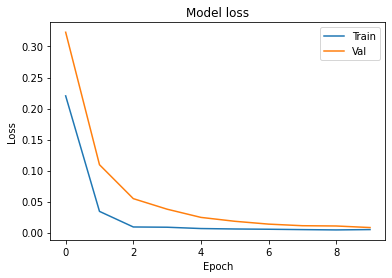

In [106]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

In [107]:
# performing predictions
predictions = model.predict(X_test) 

# unscaling the predictions
predictions = scaler_y.inverse_transform(np.array(predictions).reshape((len(predictions), 1)))

# printing the predictions
print('Predictions:')
predictions[0:5]

Predictions:


array([[50.062927],
       [50.40987 ],
       [50.737648],
       [50.576153],
       [50.18474 ]], dtype=float32)

In [108]:
# calculating the training mean-squared-error
train_loss = model.evaluate(X_train, y_train, batch_size = 1)

# calculating the test mean-squared-error
test_loss = model.evaluate(X_test, y_test, batch_size = 1)

# printing the training and the test mean-squared-errors
print('Train Loss =', round(train_loss,4))
print('Test Loss =', round(test_loss,4))

93/93 [==============================] - 0s 2ms/step - loss: 0.0023
Train Loss = 0.0022
Test Loss = 0.0023


In [111]:
# unscaling the test feature dataset, x_test
X_test = scaler_x.inverse_transform(np.array(X_test).reshape((len(X_test), len(cols))))

# unscaling the test y dataset, y_test
y_train = scaler_y.inverse_transform(np.array(y_train).reshape((len(y_train), 1)))
y_test = scaler_y.inverse_transform(np.array(y_test).reshape((len(y_test), 1)))

In [116]:
# calculating root mean squared error using sklearn.metrics package
rmse = metrics.mean_squared_error(y_test, predictions)
print('Root Mean Square Error (sklearn.metrics) =', round(np.sqrt(rmse),4))

Root Mean Square Error (sklearn.metrics) = 0.8559


In [117]:
# calculating root mean squared error
root_mean_square_error = np.sqrt(np.mean(np.power((y_test - predictions),2)))
print('Root Mean Square Error =', round(root_mean_square_error,4))

Root Mean Square Error = 0.8559


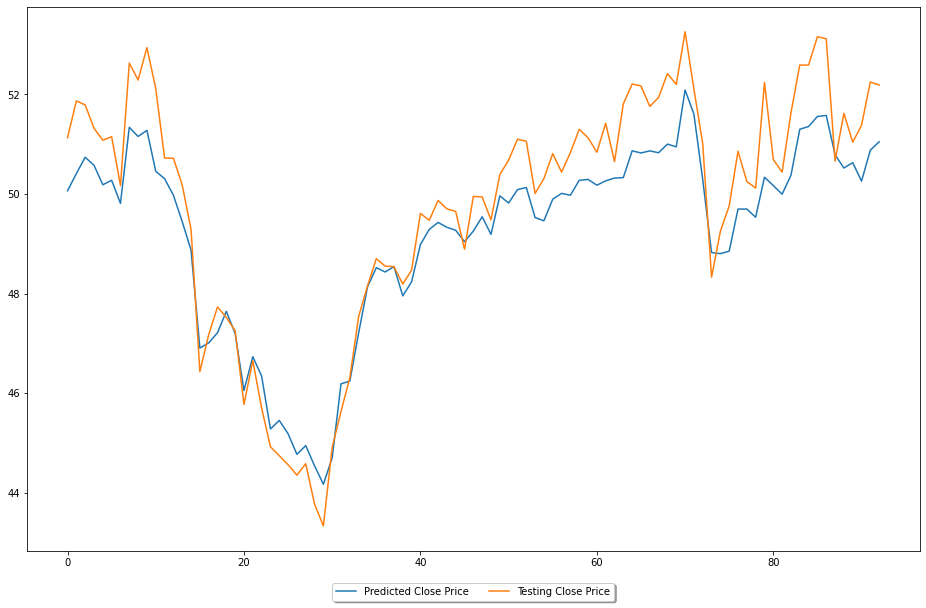

In [112]:
# plotting
plt.figure(figsize=(16,10))

# plt.plot([row[0] for row in y_train], label="Training Close Price")
plt.plot(predictions, label="Predicted Close Price")
plt.plot([row[0] for row in y_test], label="Testing Close Price")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=2)
plt.show()

In [113]:
df = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': predictions.flatten()})
df

,Actual,Predicted
0,51.13,50.062927
1,51.87,50.409870
2,51.79,50.737648
3,51.32,50.576153
4,51.08,50.184738
...,...,...
88,51.62,50.521275
89,51.04,50.629642
90,51.38,50.257877
91,52.25,50.880165


In [540]:
# setting the features dataset for prediction  
cols = ['Open',	'High',	'Low',	'Adj Close', 'ts_polarity']
x2 = data[cols]
x2

,Open,High,Low,Adj Close,ts_polarity
Date,,,,,
2016-01-04,25.65,26.34,25.50,24.44,0.070389
2016-01-05,26.44,26.46,25.60,23.83,0.133635
2016-01-06,25.14,25.59,24.97,23.36,0.072042
2016-01-07,24.67,25.03,24.11,22.38,0.074369
2016-01-08,24.64,24.78,24.19,22.50,0.051595
...,...,...,...,...,...
2019-08-26,51.47,51.80,51.26,51.12,0.072340
2019-08-27,51.97,52.14,50.88,50.54,0.117541
2019-08-28,51.03,51.43,50.83,50.88,0.061477


In [541]:
# setting the target variable as the shifted close_price
y2 = data['Close']
y2

Date
2016-01-04    26.34
2016-01-05    25.68
2016-01-06    25.17
2016-01-07    24.11
2016-01-08    24.24
              ...  
2019-08-26    51.62
2019-08-27    51.04
2019-08-28    51.38
2019-08-29    52.25
2019-08-30    52.19
Name: Close, Length: 922, dtype: float64

In [542]:
# scaling the feature dataset
scaler_x2 = preprocessing.MinMaxScaler (feature_range=(-1, 1))
x2 = np.array(x2).reshape((len(x2) ,len(cols)))
x2 = scaler_x2.fit_transform(x2)

# scaling the target variable
scaler_y2 = preprocessing.MinMaxScaler (feature_range=(-1, 1))
y2 = np.array (y2).reshape ((len( y2), 1))
y2 = scaler_y2.fit_transform (y2)

# displaying the scaled feature dataset and the target variable
x2, y2

(array([[-0.82102273, -0.80705219, -0.82155074, -0.81679389, -0.21358954],
        [-0.77613636, -0.80028209, -0.81584949, -0.8512864 ,  0.16307989],
        [-0.85      , -0.8493653 , -0.85176739, -0.8778626 , -0.2037449 ],
        ...,
        [ 0.62102273,  0.60846262,  0.62257697,  0.67825841, -0.26666607],
        [ 0.68352273,  0.65923836,  0.6704675 ,  0.72688719, -0.29654544],
        [ 0.70681818,  0.67503526,  0.67787913,  0.72292904, -0.00093206]]),
 array([[-7.87810384e-01],
        [-8.25056433e-01],
        [-8.53837472e-01],
        [-9.13656885e-01],
        [-9.06320542e-01],
        [-8.84311512e-01],
        [-8.63995485e-01],
        [-9.00112867e-01],
        [-8.70203160e-01],
        [-9.04063205e-01],
        [-9.10270880e-01],
        [-9.08577878e-01],
        [-9.15349887e-01],
        [-8.43115124e-01],
        [-8.71331828e-01],
        [-8.63431151e-01],
        [-9.55981941e-01],
        [-9.46952596e-01],
        [-9.01241535e-01],
        [-9.13656885e-

In [543]:
# preparing training and test dataset
X_train2 = x2[0 : train_end,]
X_test2 = x2[train_end+1 : len(x2),]    
y_train2 = y2[0 : train_end] 
y_test2 = y2[train_end+1 : len(y2)]  

# printing the shape of the training and the test datasets
print('Number of rows and columns in the Training set X:', X_train2.shape, 'and y:', y_train2.shape)
print('Number of rows and columns in the Test set X:', X_test2.shape, 'and y:', y_test2.shape)

Number of rows and columns in the Training set X: (828, 5) and y: (828, 1)
Number of rows and columns in the Test set X: (93, 5) and y: (93, 1)


In [544]:
# reshaping the feature dataset for feeding into the model
X_train2 = X_train2.reshape (X_train2.shape + (1,)) 
X_test2 = X_test2.reshape(X_test2.shape + (1,))

# printing the re-shaped feature dataset
print('Shape of Training set X:', X_train2.shape)
print('Shape of Test set X:', X_test2.shape)

Shape of Training set X: (828, 5, 1)
Shape of Test set X: (93, 5, 1)


In [545]:
np.random.seed(2016)
tf.random.set_seed(2016)
model=Sequential()
model.add(LSTM(32,recurrent_dropout = 0.3,activation='tanh',input_shape=(X_train2.shape[1],1)))
model.add(Dropout(0.3))
model.add(Dense(1))
model.summary()

Model: "sequential_60"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_70 (LSTM)               (None, 32)                4352      
_________________________________________________________________
dropout_69 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_60 (Dense)             (None, 1)                 33        
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
_________________________________________________________________


In [546]:
# compiling the model
model.compile(loss='mse' , optimizer='adam')

# fitting the model using the training dataset
hist = model.fit(X_train2, y_train2, validation_split=0.1, epochs=15, batch_size=62)

Epoch 1/15
13/13 [==============================] - 4s 82ms/step - loss: 0.3512 - val_loss: 0.0910
Epoch 2/15
13/13 [==============================] - 0s 7ms/step - loss: 0.2017 - val_loss: 0.0843
Epoch 3/15
13/13 [==============================] - 0s 7ms/step - loss: 0.1252 - val_loss: 0.0672
Epoch 4/15
13/13 [==============================] - 0s 8ms/step - loss: 0.0707 - val_loss: 0.0350
Epoch 5/15
13/13 [==============================] - 0s 7ms/step - loss: 0.0342 - val_loss: 0.0094
Epoch 6/15
13/13 [==============================] - 0s 8ms/step - loss: 0.0171 - val_loss: 0.0026
Epoch 7/15
13/13 [==============================] - 0s 7ms/step - loss: 0.0144 - val_loss: 0.0025
Epoch 8/15
13/13 [==============================] - 0s 10ms/step - loss: 0.0130 - val_loss: 0.0016
Epoch 9/15
13/13 [==============================] - 0s 7ms/step - loss: 0.0142 - val_loss: 0.0013
Epoch 10/15
13/13 [==============================] - 0s 7ms/step - loss: 0.0111 - val_loss: 8.8390e-04
Epoch 11/15
1

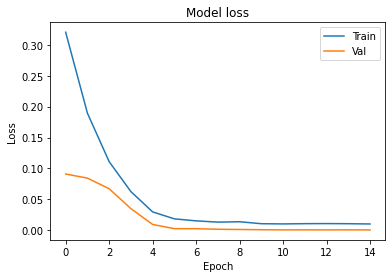

In [547]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

In [548]:
# performing predictions
predictions2 = model.predict(X_test2) 

# unscaling the predictions
predictions2 = scaler_y2.inverse_transform(np.array(predictions2).reshape((len(predictions2), 1)))

# printing the predictions
print('Predictions:')
predictions2[0:5]

Predictions:


array([[51.18346 ],
       [51.616943],
       [51.62069 ],
       [51.40349 ],
       [51.190308]], dtype=float32)

In [549]:
# calculating the training mean-squared-error
train_loss2 = model.evaluate(X_train2, y_train2, batch_size = 1)

# calculating the test mean-squared-error
test_loss2 = model.evaluate(X_test2, y_test2, batch_size = 1)

# printing the training and the test mean-squared-errors
print('Train Loss =', round(train_loss2,4))
print('Test Loss =', round(test_loss2,4))

93/93 [==============================] - 0s 2ms/step - loss: 7.1385e-04
Train Loss = 0.0011
Test Loss = 0.0007


In [550]:
# unscaling the test feature dataset, x_test
X_test2 = scaler_x2.inverse_transform(np.array(X_test2).reshape((len(X_test2), len(cols))))

# unscaling the test y dataset, y_test
y_train2 = scaler_y2.inverse_transform(np.array(y_train2).reshape((len(y_train2), 1)))
y_test2 = scaler_y2.inverse_transform(np.array(y_test2).reshape((len(y_test2), 1)))

In [551]:
# calculating root mean squared error
root_mean_square_error = np.sqrt(np.mean(np.power((y_test2 - predictions2),2)))
print('Root Mean Square Error =', round(root_mean_square_error,4))

Root Mean Square Error = 0.4734


In [552]:
# calculating root mean squared error using sklearn.metrics package
rmse = metrics.mean_squared_error(y_test2, predictions2)
print('Root Mean Square Error (sklearn.metrics) =', round(np.sqrt(rmse),4))

Root Mean Square Error (sklearn.metrics) = 0.4734


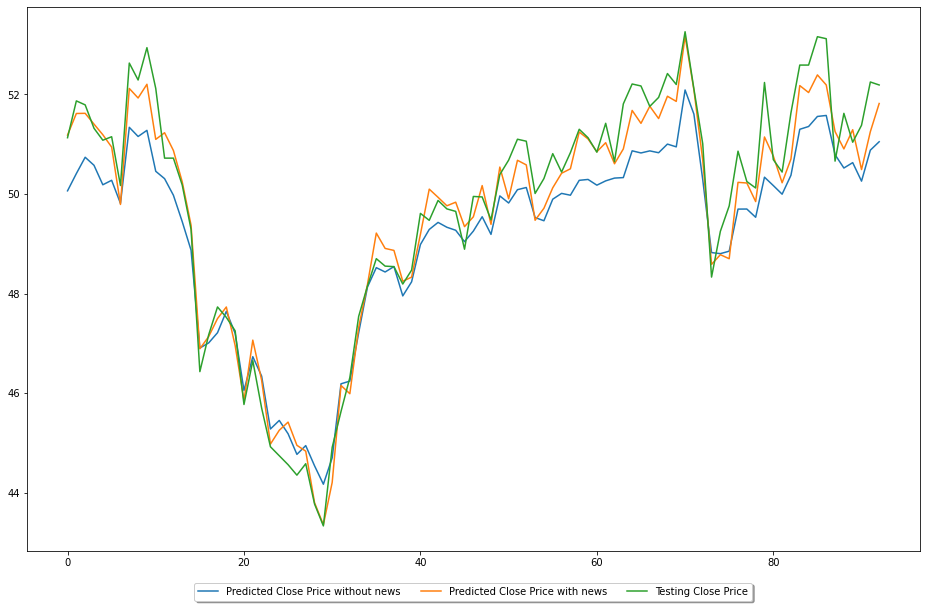

In [553]:
# plotting
plt.figure(figsize=(16,10))

# plt.plot([row[0] for row in y_train], label="Training Close Price")
plt.plot(predictions, label="Predicted Close Price without news")
plt.plot(predictions2, label="Predicted Close Price with news")
plt.plot([row[0] for row in y_test2], label="Testing Close Price")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=4)
plt.show()

In [554]:
df = pd.DataFrame({'Actual': y_test2.flatten(), 'Predicted': predictions2.flatten()})
df

,Actual,Predicted
0,51.13,51.183460
1,51.87,51.616943
2,51.79,51.620689
3,51.32,51.403488
4,51.08,51.190308
...,...,...
88,51.62,50.905506
89,51.04,51.291164
90,51.38,50.490307
91,52.25,51.251804
